## Notebook to create raster masks from polygons
Needed for semantic segmentation of raster images. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
sys.path.append('../scripts/')
import numpy as np
import matplotlib.pyplot as plt
import rasterio, rasterio.plot
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import land_cover_models as lcm
from torch.utils.data import TensorDataset, DataLoader

path_dict = loadpaths.loadpaths()

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Example tile:

(3, 8000, 8000) <class 'numpy.ndarray'>


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


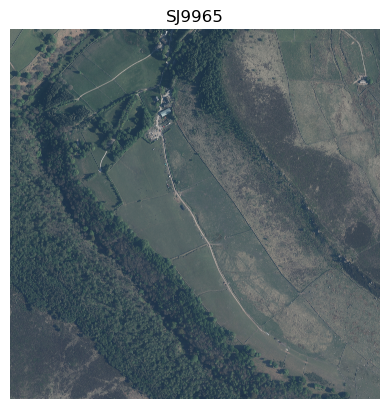

In [10]:
## Load image:

example_tiff_file = 'SJ9965.tif'
# example_tiff_file = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022/SE0800_lc_2022_mask.tif'
example_tiff_path = os.path.join(path_dict['image_path'], example_tiff_file)
# example_tiff_path = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022/SK2196_lc_2022_mask.tif'
ex_tile = lca.load_tiff(tiff_file_path=example_tiff_path, datatype='da')
lcv.plot_image_simple(im=ex_tile, name_file=example_tiff_file)

(3, 8450, 8450) <class 'numpy.ndarray'>


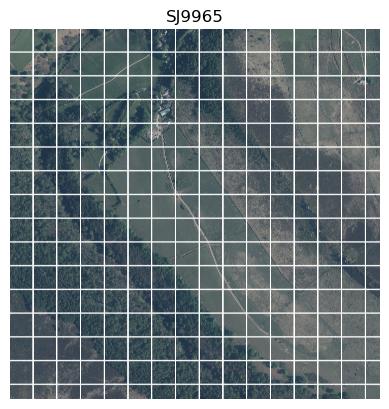

In [20]:
tmp = lcv.plot_image_as_patches(im=ex_tile, name_file=example_tiff_file)

### Automatically intersect LC polygons with tiles; and create rasterized patches:

In [7]:
## Load landcover polygons:

df_lc_80s, mapping_class_inds = lca.load_landcover(pol_path=path_dict['lc_80s_path'])
# df_lc_80s = lca.load_pols(pol_path='/home/tplas/repos/cnn-land-cover/content/evaluation_polygons/Landscape_Character_80s_2022.shp')
df_lc_80s = lca.test_validity_geometry_column(df=df_lc_80s)
df_lc_80s = lca.add_main_category_column(df_lc=df_lc_80s) 
df_lc_80s

AREA     PERIMETER  LC_N_80                         LC_D_80  \
0     2.288935e+05   1931.281171       19                Improved Pasture   
1     8.103939e+05   6180.868624       12       Upland Heath/Grass Mosaic   
2     3.024182e+06  30493.715242        7               Upland Grass Moor   
3     3.141201e+06  17829.297205        8         Blanket Peat Grass Moor   
4     5.524007e+03    360.239964       20                   Rough Pasture   
...            ...           ...      ...                             ...   
8477  2.946860e+03    210.674150       19                Improved Pasture   
8478  1.588031e+03    186.955561        1         Broadleaved High Forest   
8479  6.253066e+03    340.410463       36  Isolated Farmsteads (>0.25 ha)   
8480  1.770921e+05   2285.262979        2          Coniferous High Forest   
8481  1.544061e+04    616.843797       20                   Rough Pasture   

      MI_PRINX                                           geometry Class_Code  
0            1  POLYGON ((407724.666 411168.713, 407854.641 41...          E  
1            2  POLYGON ((407267.642 410992.244, 407326.372 41...          D  
2            3  POLYGON ((405616.816 409724.857, 405615.571 40...          D  
3            4  POLYGON ((406402.661 410926.453, 406419.695 41...          D  
4            5  POLYGON ((405569.382 410874.398, 405584.644 41...          E  
...        ...                                                ...        ...  
8477      8478  POLYGON ((416356.527 348866.777, 416357.591 34...          E  
8478      8479  POLYGON ((412660.720 348649.559, 412658.280 34...          C  
8479      8480  POLYGON ((412871.439 348609.371, 412858.033 34...          H  
8480      8481  POLYGON ((411786.076 405491.149, 411803.349 40...          C  
8481      8482  POLYGON ((417894.306 382937.175, 417901.784 38...          E  

[8482 rows x 7 columns]

In [10]:
# df_lc_80s = df_lc_80s.drop('AREA', axis=1)
# df_lc_80s['area'] = df_lc_80s['geometry'].area

df_h = df_lc_80s[df_lc_80s['Class_Code'] == 'H']
area_h = df_h['area'].sum()
total_area = df_lc_80s['area'].sum()

print('Total area: ', total_area / 1e4)
print('Area H: ', area_h / 1e4)
print('Percentage H: ', area_h/total_area)



Total area:  143835.0136998267
Area H:  2935.024649254558
Percentage H:  0.02040549497481707


In [ ]:
# ## Get intersection of polygons with tiles
# # df_tiles = lca.create_df_with_tiff_coords(tiff_paths=lca.get_all_tifs_from_dir(path_dict['image_path']), verbose=1)  # get df of square polygons of tiles 
# df_tiles = lca.create_df_with_tiff_coords(tiff_paths=lca.get_all_tifs_from_dir('/home/tplas//data/gis/most recent APGB 12.5cm aerial/gradbach_6tiles/12.5cm Aerial Photo/117383-1_RGB_1_Shape/tiles/'), verbose=1)  # get df of square polygons of tiles 
# # df_tiles = lca.create_df_with_tiff_coords(tiff_paths=lca.get_all_tifs_from_dir(path_dict['image_path']), verbose=1)  # get df of square polygons of tiles 
# dict_intersect_pols = lca.get_pols_for_tiles(df_pols=df_lc_80s, df_tiles=df_tiles)

In [8]:
## Load shp files of tiles and intersect with PD LC:

df_tiles_sample = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/CDE_training_tiles/CDE_training_tiles.shp')
# df_tiles_sample = lca.load_pols('/home/tplas/data/gis/most recent APGB 12.5cm aerial/urban_tiles/3_urban_tiles/3_urban_tiles.shp')
dict_intersect_pols_tiles_sample = lca.get_pols_for_tiles(df_pols=df_lc_80s, df_tiles=df_tiles_sample, col_name='PLAN_NO',
                                                          extract_main_categories_only=True)
df_tiles_sample_lc = pd.concat(list(dict_intersect_pols_tiles_sample.values())).reset_index(drop=True)


100%|██████████| 11/11 [00:00<00:00, 46.87it/s]


In [10]:
## Convert all polygons labels to raster and save:

dict_shp = dict_intersect_pols_tiles_sample
# save_mask_dir = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022/'
# save_mask_dir = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/urban_tiles/tiles/117637_20221207/tile_masks/'
save_mask_dir = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/tile_masks/'
                                
for key_tile, df_tile in tqdm(dict_shp.items()):
    dict_shp[key_tile] = lca.add_main_category_index_column(df_tile)
    ex_raster = lca.convert_shp_mask_to_raster(df_shp=df_tile, filename=key_tile + '_lc_80s_mask', 
                                maskdir=save_mask_dir, 
                                col_name='class_ind',
                                # ex_tile=ex_raster,
                                # resolution=(-0.125, 0.125),
                                plot_raster=False, # whether to plot
                                save_raster=True, # whether to store on disk
                                verbose=0)
    assert ex_raster['class_ind'].shape == (8000, 8000), key_tile


100%|██████████| 11/11 [00:37<00:00,  3.38s/it]


### Some plots of class distributions:

Text(0.5, 1.0, 'Distribution of LC of entire PD')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


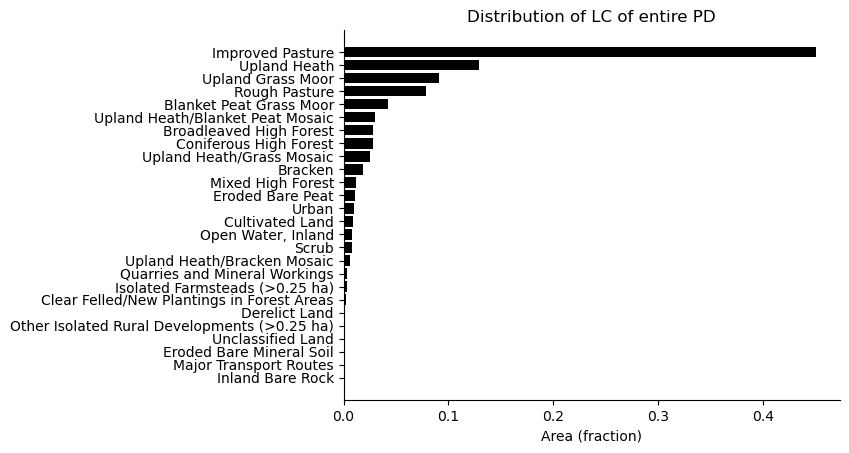

In [5]:
ax_distr, _ = lcv.plot_distr_classes_from_shape(df_lc=df_lc_80s)
ax_distr.set_title('Distribution of LC of entire PD')

Text(0.5, 1.0, 'Distribution of LC of tiles-few-changes data set')

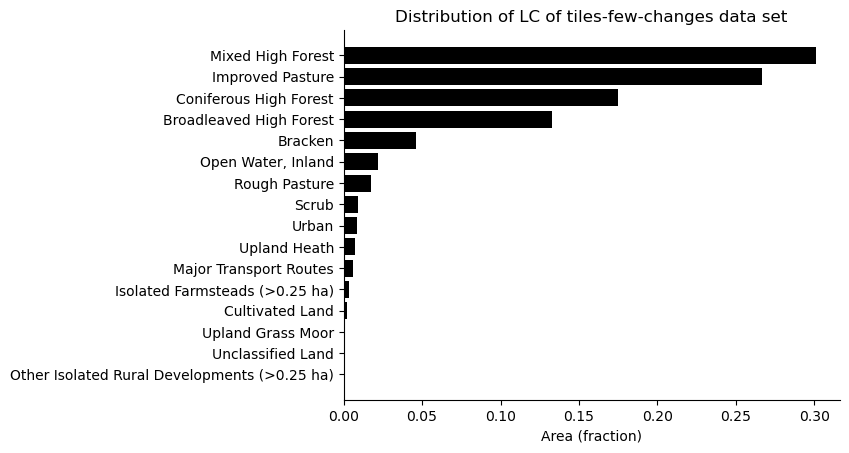

In [6]:
ax_distr, _ = lcv.plot_distr_classes_from_shape(df_lc=df_tiles_few_changes_lc)
ax_distr.set_title('Distribution of LC of tiles-few-changes data set')

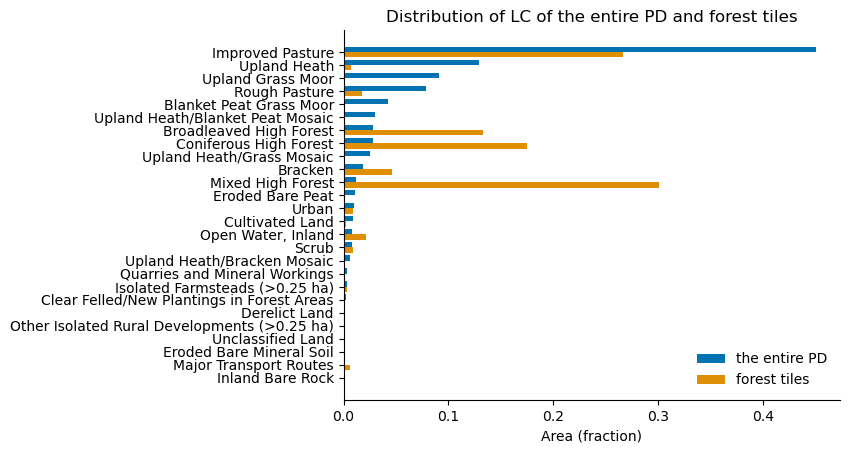

In [7]:
ax_distr, _ = lcv.plot_distr_classes_from_multiple_shapes(dict_dfs_lc={'the entire PD': df_lc_80s, 'forest tiles': df_tiles_few_changes_lc})

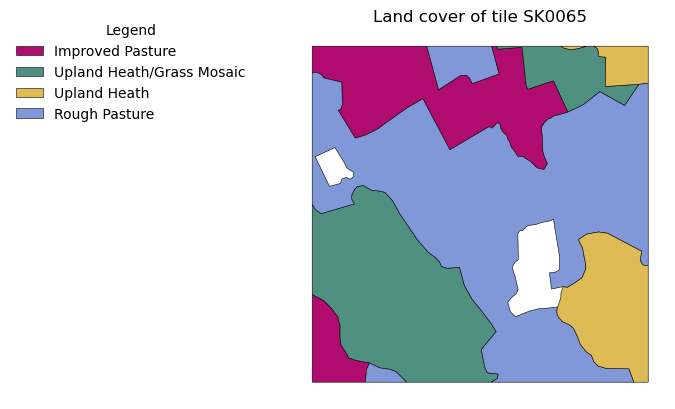

In [8]:
_ = lcv.plot_lc_from_gdf_dict(df_pols_tiles=dict_intersect_pols, tile_name="SK0065")

Current data size cube is 512.128008 MB
New cube data size is 64.128008 MB


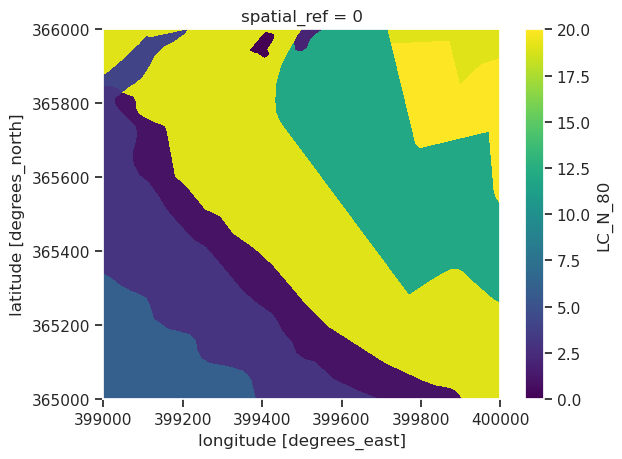

In [137]:
## Example: convert polygons labels to raster:
dict_shp = dict_intersect_pols
key_tile = "SJ9965"

ex_raster = lca.convert_shp_mask_to_raster(df_shp=dict_shp[key_tile], filename=key_tile + '_lc_80s_mask', 
                                plot_raster=True, # whether to plot
                                save_raster=False, # whether to store on disk
                                verbose=1)

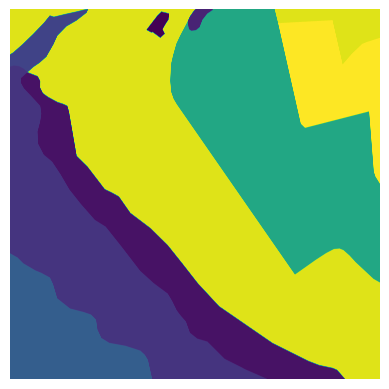

In [11]:
## Load saved raster mask
ex_mask_tif = lca.load_tiff(tiff_file_path=os.path.join(path_dict['mask_path'], 'SJ9965' + '_lc_80s_mask.tif'))
lcv.plot_image_simple(im=ex_mask_tif)

## Create Patches and save:

In [3]:
# list_tiff_files = lca.get_all_tifs_from_dir(dirpath='/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/')
list_tiff_files = lca.get_all_tifs_from_dir(dirpath='/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/')
list_mask_files = lca.get_all_tifs_from_dir(dirpath='/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/tile_masks/')
print(f'Found {len(list_tiff_files)} images and {len(list_mask_files)} masks')
print(list_tiff_files[:4])

Found 11 images and 11 masks
['/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/SK0560.tif', '/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/SK0796.tif', '/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/SK2669.tif', '/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/SK2567.tif']


## TMP:

In [40]:
LCU = lcm.load_model(filename='LCU_2023-01-23-2018.data')
LCU.model_name

Loaded LCU_2023-01-23-2018
loss_function is focal_loss
n_max_epochs is 60
LandCoverUNet class using FocalLoss_2()
11 training tiles CDE


'LCU_2023-01-23-2018'

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Divided tile
Predicting patches:


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


torch.Size([225, 512, 512]) (15, 15, 512, 512) (3, 7680, 7680)
(7680, 7680) (8000, 8000) (3, 8000, 8000) (15, 15, 512, 512)
Shape of prediction: (7680, 7680)


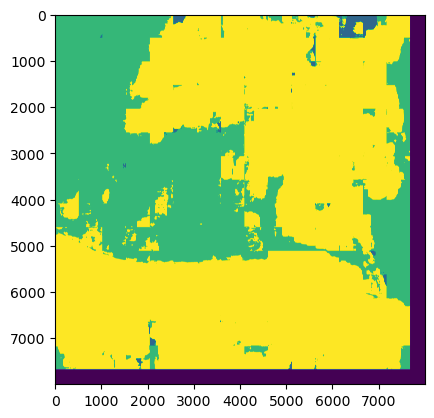

In [103]:
pred_no_padding = lcm.prediction_one_tile(model=LCU, tilepath=list_tiff_files[0])
print(f'Shape of prediction: {pred_no_padding[2]}')
plt.imshow(pred_no_padding[0].values)

In [119]:
pred_padding = lcm.prediction_one_tile(model=LCU, tilepath=list_tiff_files[0], padding=12)
print(f'Shape of prediction: {pred_padding[2]}')
plt.imshow(pred_padding[0].values)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Divided tile


AssertionError: patches_img has shape (1, 15, 15, 3, 512, 512), but expected (1, 16, 16, 3, 512, 512)

In [101]:
import patchify

tmp1 = np.arange(36).reshape(6, 6).reshape(2, 2, 3, 3)
# tmp1
patchify.unpatchify(tmp1, (5, 5))
np.product(tmp1.shape)

36

In [78]:
image_tile = lca.load_tiff(list_tiff_files[0], datatype='da')
mask_tile = lca.load_tiff(list_mask_files[0], datatype='np')

# lcv.plot_image_simple(im=image_tile)
# patches_img, patches_mask = lca.create_image_mask_patches(image=image_tile, mask=None, 
                                                              patch_size=512, padding=60)

Expected number of patches: 17 (patch size: 512, step size: 452
(1, 17, 17, 3, 512, 512) (3, 8000, 8000)


In [79]:
patches_img.shape

(289, 3, 512, 512)

Text(0, 0.5, 'number of patches')

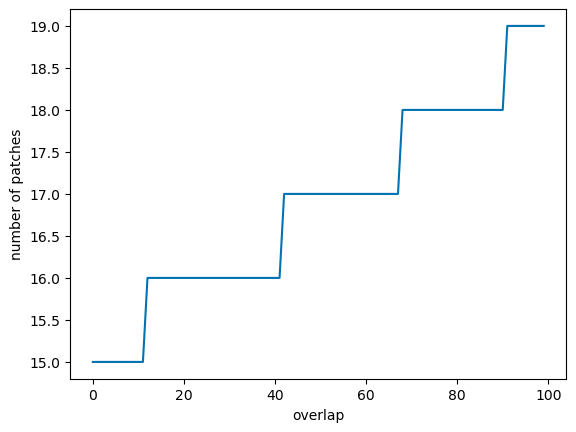

In [36]:
def tmp_f(overlap):
    return int(np.floor(8000 / (512 - overlap)))

xarr = np.arange(100)
plt.plot(xarr, [tmp_f(x) for x in xarr])
plt.xlabel('overlap')
plt.ylabel('number of patches')

In [31]:
patches_img.shape, patches_mask.shape

((324, 3, 512, 512), (324, 512, 512))

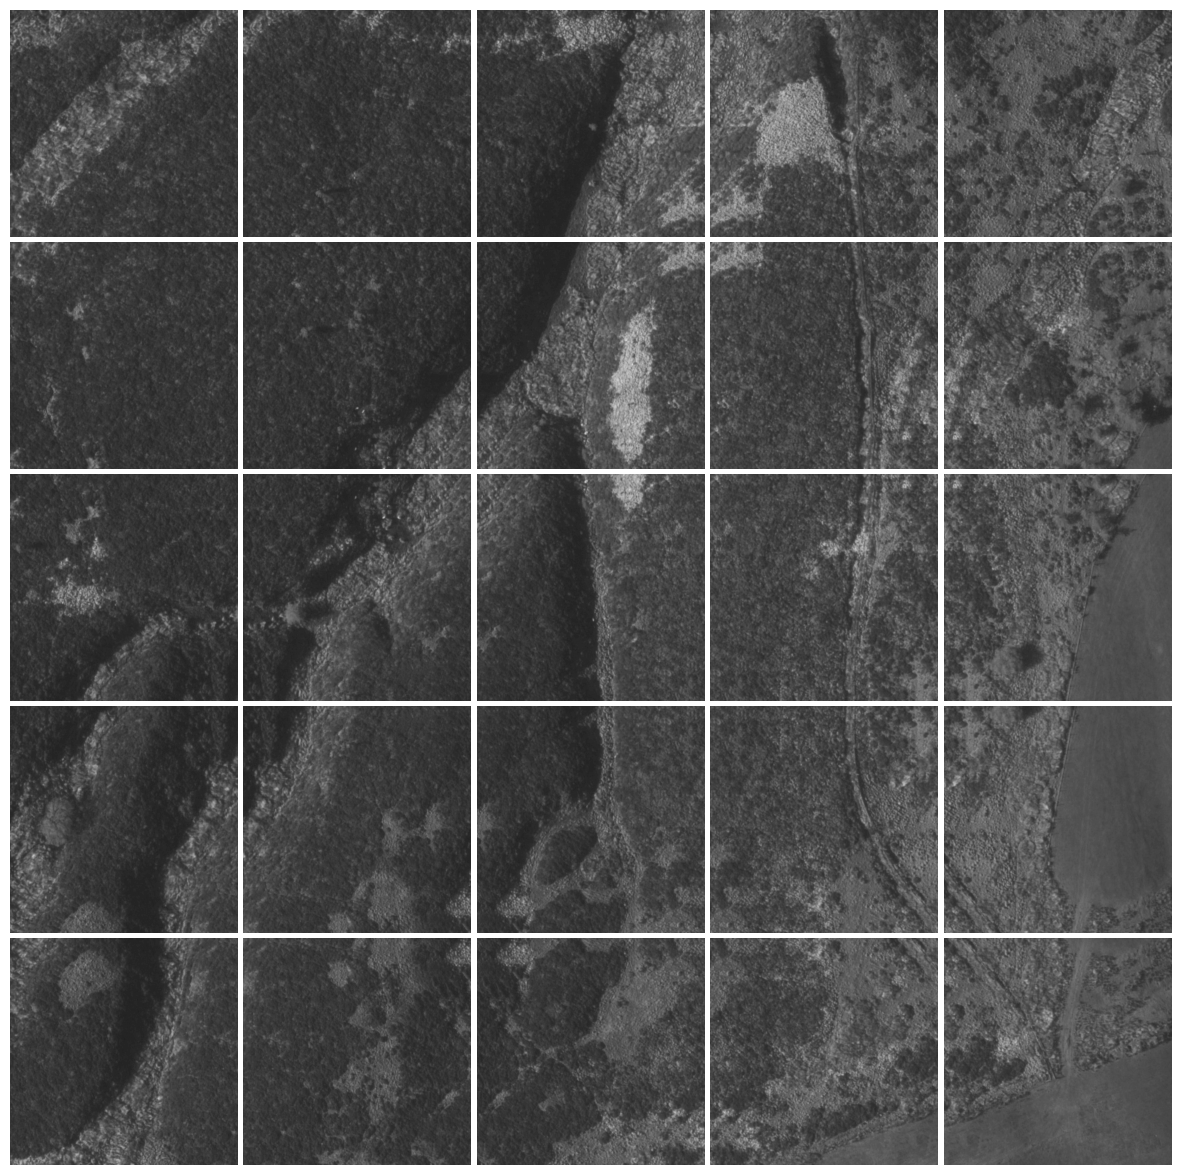

In [38]:
n_patches_plot = 5
fig, ax = plt.subplots(n_patches_plot, n_patches_plot, figsize=(15, 15), gridspec_kw={'wspace': 0.02, 'hspace': 0.02})
n_patches_per_side = int(np.sqrt(patches_img.shape[0]))

for i in range(n_patches_plot):
    for j in range(n_patches_plot):
        ax[i, j].imshow(patches_img[i * n_patches_per_side + j, 0, :, :], vmin=0, vmax=255, cmap='gray')
        ax[i, j].axis('off')
        # ax[i, j].set_title(f'Patch {i * n_patches_per_side + j}')

## Continue:

In [12]:
dir_im_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/images/'
dir_mask_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/masks/'

In [13]:
lca.create_and_save_patches_from_tiffs(list_tiff_files=list_tiff_files, list_mask_files=list_mask_files,
                                       dir_im_patches=dir_im_patches, dir_mask_patches=dir_mask_patches,
                                       mask_fn_suffix='_lc_80s_mask.tif',
                                       save_files=True)

11it [00:05,  1.91it/s]


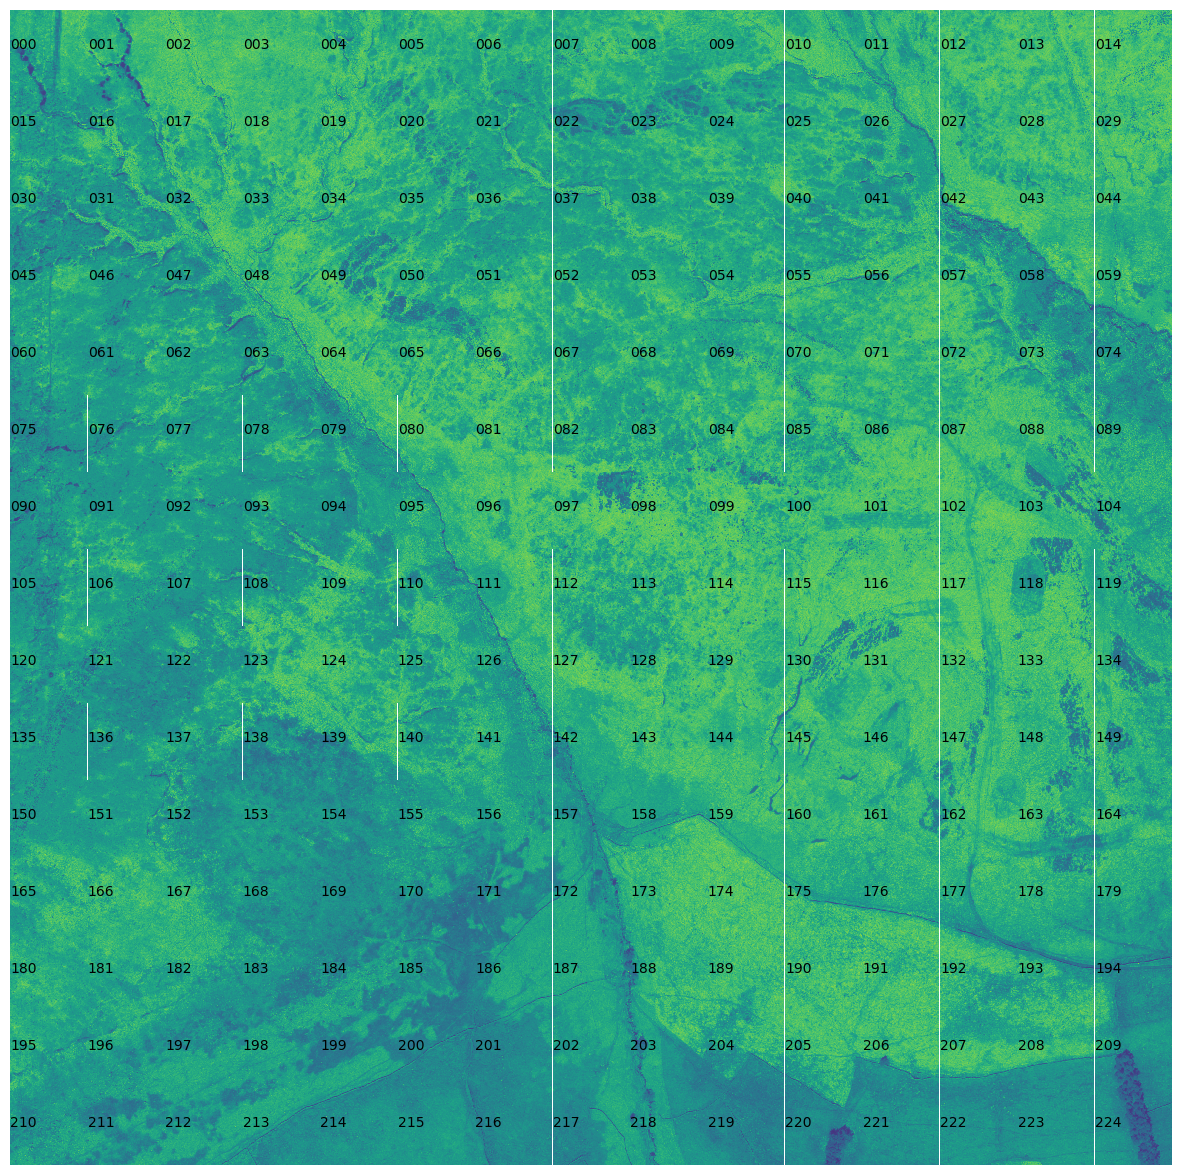

In [15]:
dict_npys = {}
for ii in range(225):
    tmp_path = f'/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/images/SE0800_patch{str(ii).zfill(3)}.npy' 
    # tmp_path = f'/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/masks_2022/SE0800_patch{str(ii).zfill(3)}_lc_2022_mask.npy' 
    # tmp_path = f'/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/images/SK2969_patch{str(ii).zfill(3)}.npy' 
    # tmp_path = f'/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/masks/SK0560_patch{str(ii).zfill(3)}_lc_80s_mask.npy' 
    dict_npys[ii] = np.load(tmp_path, 'r')

fig, ax = plt.subplots(15, 15, figsize=(15, 15), gridspec_kw={'wspace': 0, 'hspace': 0})

icol, irow = 0, 0
for ii, im in dict_npys.items():
    curr_ax = ax[irow, icol]
    tmp = curr_ax.imshow(im[0, :, :], interpolation='none', vmin=0 ,vmax=255)
    # tmp = curr_ax.imshow(im, interpolation='none', vmin=0 ,vmax=5)
    curr_ax.text(s=str(ii).zfill(3), x=im.shape[0] / 2, y=im.shape[1] / 2)
    lcv.naked(curr_ax)
    icol += 1 
    if icol == 15:
        irow += 1
        icol =0 
    
# plt.colorbar(tmp)

## Notebook to create train & test data sets
- Take tile tiffs, and create patches of image & LC mask
- Save patches to be loaded by a DataLoader for training/testing

## Notebook to create label mapping transformations
- Map old labels to new labels
- Old labels: 1980s classification scheme
- Multiple new label schemes possible.


In [5]:
# save_folder = '/home/tplas/repos/cnn-land-cover/content/label_mapping_dicts/'
dict_mapping = lca.create_empty_label_mapping_dict()

In [18]:
tmp = lca.create_new_label_mapping_dict(save_mapping=True, mapping_type='main_categories')